In [202]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import KBinsDiscretizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# from scipy.special import boxcox1p

from sklearn import metrics
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

### Load and prepare data

In [203]:
pd.set_option('display.max_columns', None)

In [204]:
df = pd.read_csv('radekhiv.csv', delimiter=';')

In [205]:
df

,year,month,day,hour,generation,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,2022,6,22,0,0.0,"12,4","12,4","9,2","80,83",0,0,NaN,0,0,"41,8","14,4",290,"1007,9","91,1",10,0,0,0,10,Overcast,cloudy,"33177099999,33393099999"
1,2022,6,22,1,0.0,"12,5","12,5",9,"79,23",0,0,NaN,0,0,"43,9","24,1","281,1",1007,"95,7","24,1",0,0,0,10,Overcast,cloudy,remote
2,2022,6,22,2,0.0,"12,7","12,7",9,"78,19",0,0,NaN,0,0,"49,3",27,"289,8",1007,"95,3","24,1",0,0,0,10,Overcast,cloudy,remote
3,2022,6,22,3,0.0,"10,9","10,9","8,1","82,85",0,0,NaN,0,0,"49,3","10,8",300,"1009,8",80,10,0,0,0,10,Partially cloudy,partly-cloudy-night,33393099999
4,2022,6,22,4,0.0,"12,2","12,2","8,8","79,72",0,0,rain,0,0,"50,4","27,4","293,7",1007,"97,1","20,8",0,0,0,10,Overcast,cloudy,remote
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,2023,11,22,19,-2.0,"-4,3","-7,7",-7,"81,44",0,0,NaN,0,"0,6","14,8","7,6","328,5",1028,"44,2","24,1",0,0,0,10,Partially cloudy,partly-cloudy-night,remote
12453,2023,11,22,20,-2.0,"-4,5","-4,5","-6,8","84,23",0,0,NaN,0,"0,6","13,7","3,6",17,"1029,1","88,9",10,0,0,0,10,Partially cloudy,partly-cloudy-night,"33177099999,33393099999"
12454,2023,11,22,21,-2.0,-5,"-8,2","-7,3","83,89",0,0,NaN,0,"0,6","13,7","6,8","312,7",1028,"66,2","24,1",0,0,0,10,Partially cloudy,partly-cloudy-night,remote
12455,2023,11,22,22,-2.0,"-5,1","-7,4","-7,4","83,88",0,0,NaN,0,"0,6","12,2",5,"293,2",1028,"47,8","24,1",0,0,0,10,Partially cloudy,partly-cloudy-night,remote


In [206]:
df['preciptype'].value_counts()

preciptype
rain            1908
snow             466
rain,snow         75
freezingrain      10
Name: count, dtype: int64

In [207]:
df2 = df.copy()
num_columns = ['temp', 'feelslike', 'dew', 'humidity', 'precip', 'snow',
               'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
               'cloudcover', 'visibility', 'solarenergy']

category_columns = ['conditions', 'icon', 'stations']

def parse_float(str):
    return float(str.replace(",", "."))

In [208]:
df2['conditions'] = df2['conditions'].map(lambda x: x.lower())
df2['conditions'].value_counts()

conditions
overcast                                    5314
partially cloudy                            4954
clear                                       1466
rain, overcast                               368
rain, partially cloudy                       142
snow, overcast                               118
snow, rain, overcast                          67
freezing drizzle/freezing rain, overcast      10
snow, partially cloudy                         9
snow, rain, partially cloudy                   8
rain                                           1
Name: count, dtype: int64

In [209]:
df2['conditions'] = df2['conditions'].str.replace('.*partially cloudy.*','partially cloudy', regex=True)
df2['conditions'] = df2['conditions'].str.replace('^rain.*', 'rain', regex=True)
df2['conditions'] = df2['conditions'].str.replace('^snow.*', 'snow', regex=True)
df2['conditions'] = df2['conditions'].str.replace('.*rain.*', 'rain', regex=True)
df2['conditions'].value_counts()

conditions
overcast            5314
partially cloudy    5113
clear               1466
rain                 379
snow                 185
Name: count, dtype: int64

In [210]:
for c in num_columns:
    df2[c] = df[c].apply(parse_float).astype('float64')

for c in category_columns:
    df2[c] = df2[c].map(lambda x: str(x).lower()).astype('category')

In [211]:
# set preciptype column
df2['preciptype'] = df['preciptype'].apply(lambda x: 0 if pd.isnull(x) else 1).astype('int')

In [212]:
df2['preciptype'].value_counts()

preciptype
0    9998
1    2459
Name: count, dtype: int64

In [213]:
df2 = df2.drop(columns=['year', 'month', 'day', 'hour'], axis=1)

In [214]:
df2['stations'].value_counts()

stations
remote                     9056
33177099999,33393099999    3216
33177099999                 108
33393099999                  77
Name: count, dtype: int64

In [215]:
df2['stations'] = df2['stations'].map({'remote': 1, '33177099999,33393099999': 2, '33177099999': 3, '33393099999': 4})

In [216]:
df2['stations'].value_counts()

stations
1    9056
2    3216
3     108
4      77
Name: count, dtype: int64

In [217]:
df2 = df2.dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12454 entries, 0 to 12456
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   generation        12454 non-null  float64 
 1   temp              12454 non-null  float64 
 2   feelslike         12454 non-null  float64 
 3   dew               12454 non-null  float64 
 4   humidity          12454 non-null  float64 
 5   precip            12454 non-null  float64 
 6   precipprob        12454 non-null  int64   
 7   preciptype        12454 non-null  int64   
 8   snow              12454 non-null  float64 
 9   snowdepth         12454 non-null  float64 
 10  windgust          12454 non-null  float64 
 11  windspeed         12454 non-null  float64 
 12  winddir           12454 non-null  float64 
 13  sealevelpressure  12454 non-null  float64 
 14  cloudcover        12454 non-null  float64 
 15  visibility        12454 non-null  float64 
 16  solarradiation    12454 non

In [218]:
df2.describe(include = 'category')

,conditions,icon,stations
count,12454,12454,12454
unique,5,8,4
top,overcast,cloudy,1
freq,5313,5020,9055


In [219]:
df2.describe()

,generation,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk
count,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000,12454.000000
mean,136.950217,11.596322,10.548739,7.171230,77.199560,0.097667,5.805364,0.197447,0.005380,0.617057,20.118492,9.665947,193.558190,1016.432439,72.096258,19.682094,143.363979,0.515521,1.425165,10.050185
std,224.132203,8.612704,9.854132,6.898846,17.645575,0.866644,23.385424,0.398088,0.051384,2.266629,10.439924,5.490679,98.586108,8.134145,33.101019,7.742533,228.333923,0.822732,2.304733,2.747631
min,-2.000000,-13.900000,-18.700000,-15.100000,22.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.700000,0.000000,0.000000,984.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.000000,4.400000,2.300000,1.400000,66.175000,0.000000,0.000000,0.000000,0.000000,0.000000,12.200000,5.400000,109.100000,1011.400000,51.100000,15.500000,0.000000,0.000000,0.000000,10.000000
50%,4.000000,11.900000,11.900000,7.800000,82.860000,0.000000,0.000000,0.000000,0.000000,0.000000,19.100000,9.000000,201.850000,1017.000000,87.200000,24.100000,6.000000,0.000000,0.000000,10.000000
75%,182.000000,18.100000,18.100000,12.800000,91.100000,0.000000,0.000000,0.000000,0.000000,0.000000,25.900000,12.800000,279.000000,1021.000000,100.000000,24.100000,211.000000,0.800000,2.000000,10.000000
max,864.000000,35.400000,34.600000,22.100000,100.000000,28.545000,100.000000,1.000000,1.600000,17.500000,89.300000,40.000000,360.000000,1048.500000,100.000000,50.000000,928.000000,3.300000,9.000000,75.000000


In [220]:
df2.head()

,generation,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,0.0,12.4,12.4,9.2,80.83,0.0,0,0,0.0,0.0,41.8,14.4,290.0,1007.9,91.1,10.0,0,0.0,0,10,overcast,cloudy,2
1,0.0,12.5,12.5,9.0,79.23,0.0,0,0,0.0,0.0,43.9,24.1,281.1,1007.0,95.7,24.1,0,0.0,0,10,overcast,cloudy,1
2,0.0,12.7,12.7,9.0,78.19,0.0,0,0,0.0,0.0,49.3,27.0,289.8,1007.0,95.3,24.1,0,0.0,0,10,overcast,cloudy,1
3,0.0,10.9,10.9,8.1,82.85,0.0,0,0,0.0,0.0,49.3,10.8,300.0,1009.8,80.0,10.0,0,0.0,0,10,partially cloudy,partly-cloudy-night,4
4,0.0,12.2,12.2,8.8,79.72,0.0,0,1,0.0,0.0,50.4,27.4,293.7,1007.0,97.1,20.8,0,0.0,0,10,overcast,cloudy,1


### Visualisation

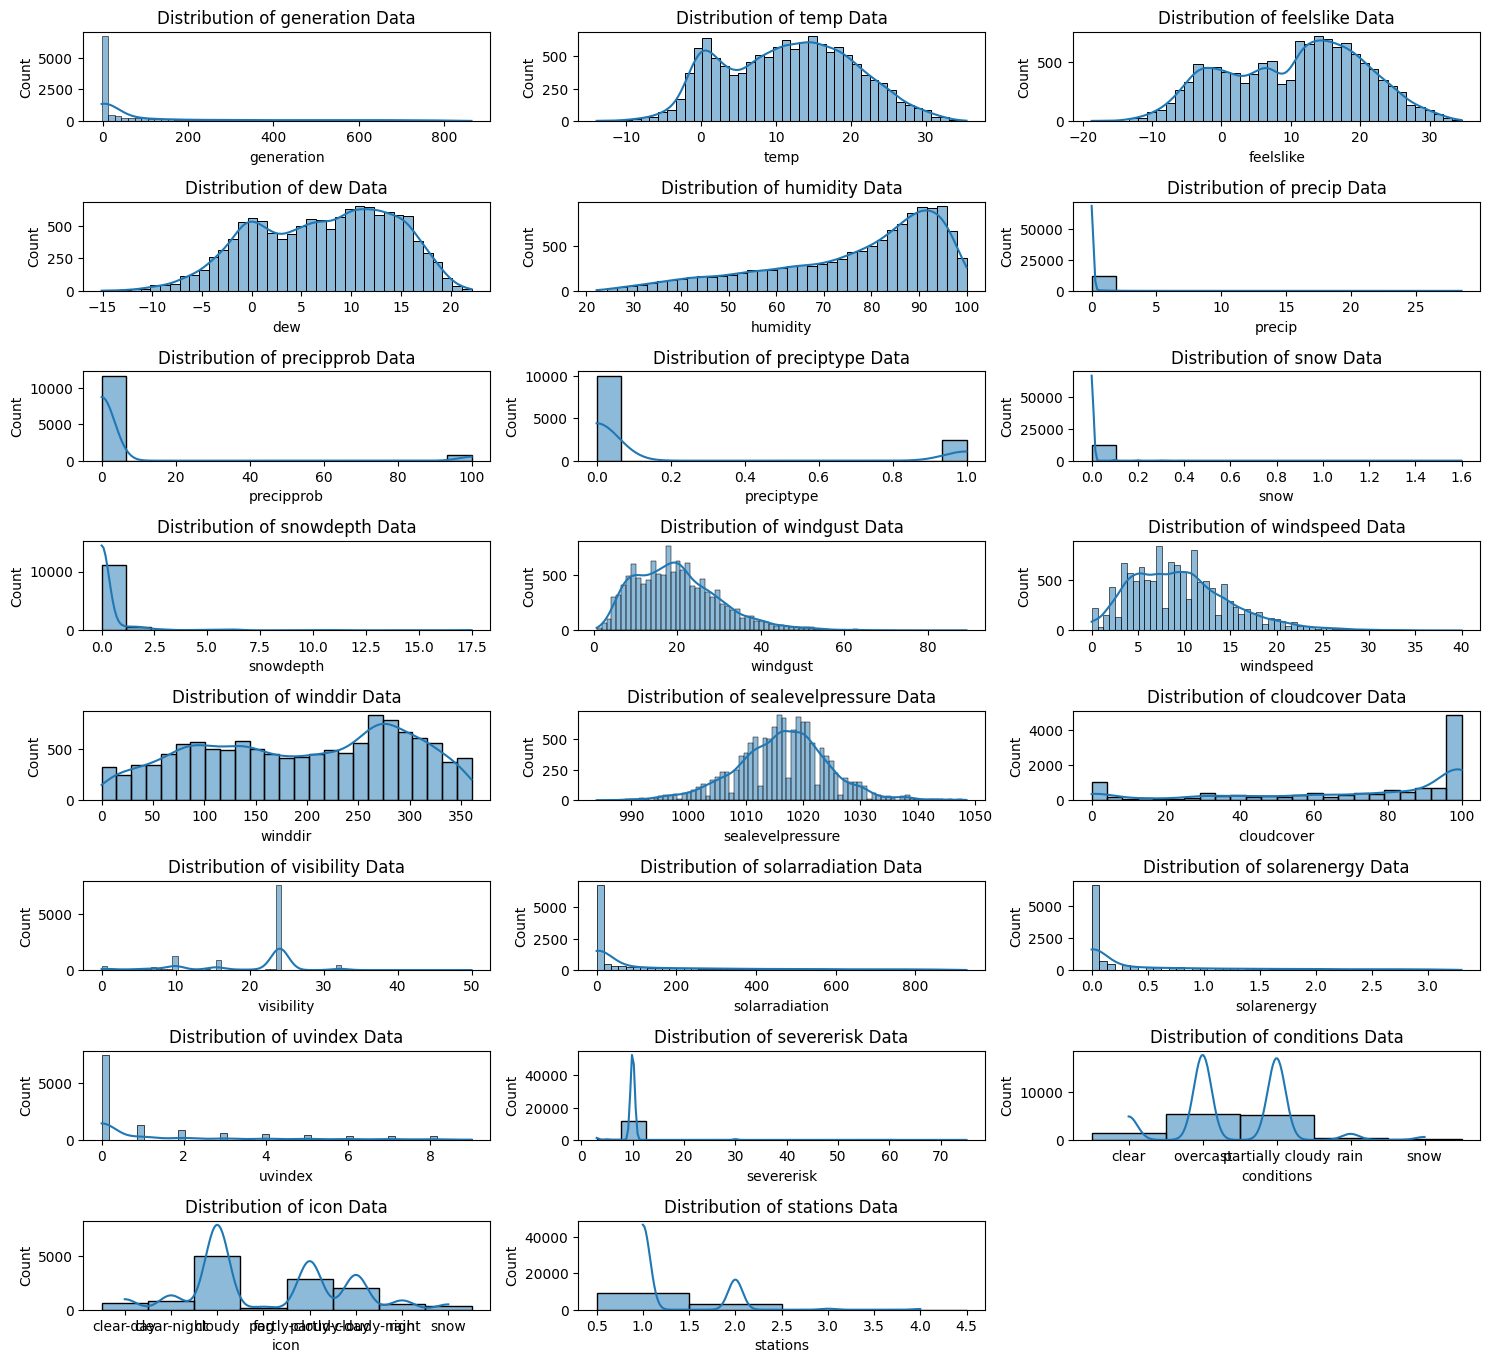

In [221]:
plt.figure(figsize=(15, 15))
for i,col in enumerate(df2.columns,1):
    # print(col)
    #if i >= len(df2.columns):
    #    break
    plt.subplot(9, 3, i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df2[col], kde=True)
    plt.tight_layout()
    plt.plot()

### Prepare models dataset

In [222]:
df3 = df2.copy()

# Prepare category columns
le = LabelEncoder()
for col in category_columns:
    df3[col] = le.fit_transform(df2[col])

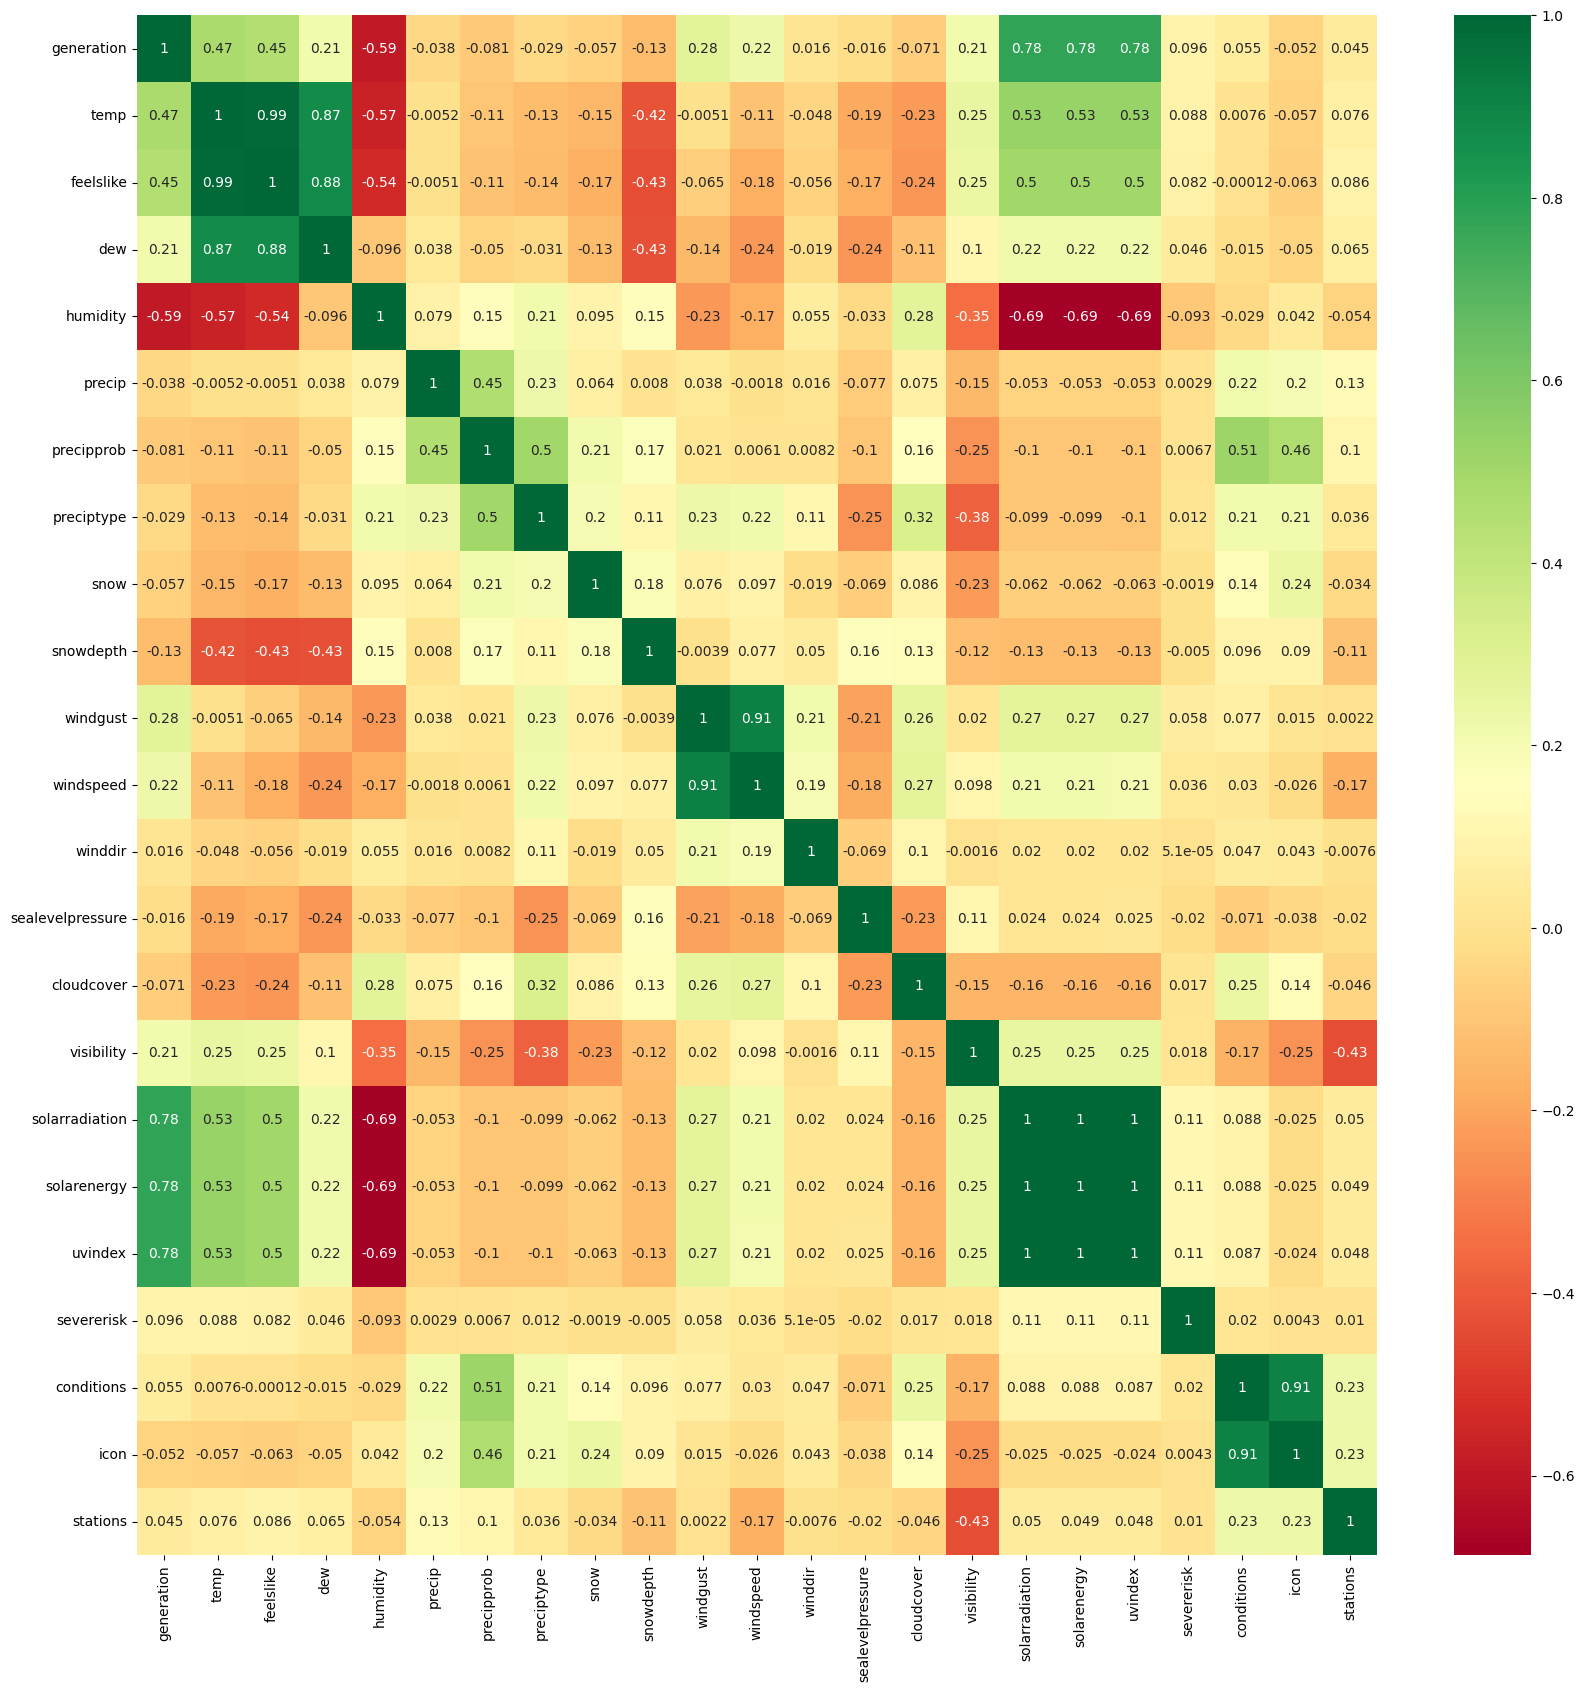

In [223]:
# Correlation Matrix
corrmat = df3.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 20))
g=sns.heatmap(df3.corr() ,annot=True, cmap="RdYlGn")

In [224]:
# Drop dependent columns
dependent_columns = ['feelslike', 'solarradiation', 'uvindex', 'windgust', 'icon', 'dew']
df3 = df3.drop(columns=dependent_columns, axis=1)

In [225]:
jobs = 6
num_columns = list(set(df2.columns) - set(category_columns) - set(dependent_columns))

def get_metrics(X, y, model, label):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    model.fit(X_train, y_train)

    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)

    return {"model": label,
            "r2 train": "%.2f" % metrics.r2_score(y_train, y_hat_train),
            "r2 test": "%.2f" % metrics.r2_score(y_test, y_hat_test),
            "mse train": "%.2f" % metrics.mean_squared_error(y_train, y_hat_train),
            "mse test": "%.2f" % metrics.mean_squared_error(y_test, y_hat_test)
           }

def get_models():
    return {"LinearRegression": LinearRegression(),
            "DecisionTreeRegressor": DecisionTreeRegressor(),
            "KNeighborsRegressor": KNeighborsRegressor(),
            "XGBRegressor": XGBRegressor(),
            "RandomForestRegressor": RandomForestRegressor(n_jobs=jobs)
            }

def get_models_metrics(models, X, y):
    series = []
    for label, model in models.items():
        start = time.time()
        metrics_ = get_metrics(X, y, model, label)
        end = time.time()
        metrics_["exec_time"] = round(end - start, 2)
        series.append(pd.Series(metrics_))
        print("Handled", label)

    return pd.concat(series, axis=1).T.set_index("model")

def get_features_and_target(models_df):
    rscaler = MinMaxScaler()
    result_df = pd.DataFrame(rscaler.fit_transform(models_df[num_columns]))
    result_df.columns = num_columns
    
    y = result_df['generation']
    X = result_df.drop(columns=['generation'], axis=1)

    return X, y

### Analyse models (first iteration)

In [226]:
X, y = get_features_and_target(df3)
models = get_models()

metrics_df = get_models_metrics(models, X, y)

Handled LinearRegression
Handled DecisionTreeRegressor
Handled KNeighborsRegressor
Handled XGBRegressor
Handled RandomForestRegressor


In [227]:
metrics_df

,r2 train,r2 test,mse train,mse test,exec_time
model,,,,,
LinearRegression,0.63,0.62,0.02,0.02,0.04
DecisionTreeRegressor,1.00,0.46,0.00,0.04,0.15
KNeighborsRegressor,0.78,0.67,0.02,0.02,0.91
XGBRegressor,0.95,0.71,0.00,0.02,0.11
RandomForestRegressor,0.96,0.72,0.00,0.02,1.2


### Analyse models (change target value to normal distribution)

In [228]:
df4 = df3.copy()

<Axes: xlabel='generation', ylabel='Count'>

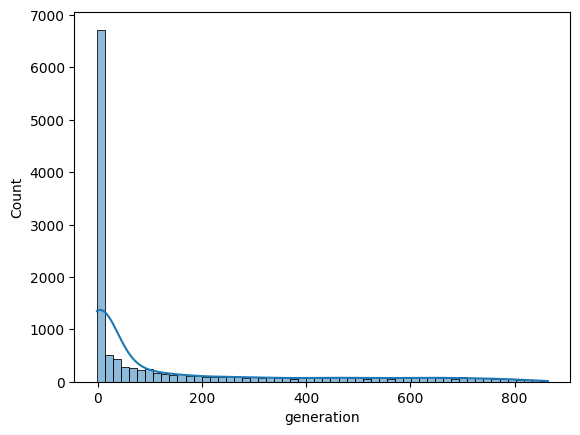

In [229]:
# Research target value
sns.histplot(df4['generation'], kde=True)

In [230]:
# Log-transformation of the target variable
# use the numpy fuction log1p which  applies log(1+x)
min_generation = df4['generation'].min()
df4['generation'] = np.log1p(df4['generation'] + (1-min_generation))

In [231]:
df4['generation'].describe()

count    12454.000000
mean         3.143927
std          2.085360
min          0.693147
25%          1.386294
50%          2.079442
75%          5.225747
max          6.766192
Name: generation, dtype: float64

<Axes: xlabel='generation', ylabel='Count'>

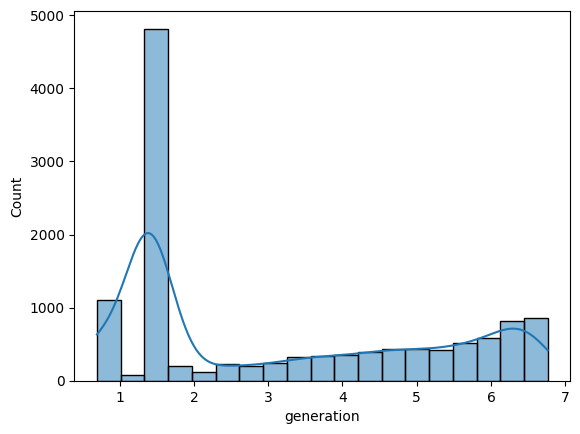

In [232]:
sns.histplot(df4['generation'], kde=True)

In [233]:
X, y = get_features_and_target(df4)
models = get_models()

metrics_df = get_models_metrics(models, X, y)
metrics_df

Handled LinearRegression
Handled DecisionTreeRegressor
Handled KNeighborsRegressor
Handled XGBRegressor
Handled RandomForestRegressor


,r2 train,r2 test,mse train,mse test,exec_time
model,,,,,
LinearRegression,0.63,0.63,0.04,0.04,0.02
DecisionTreeRegressor,1.00,0.74,0.00,0.03,0.14
KNeighborsRegressor,0.83,0.74,0.02,0.03,0.92
XGBRegressor,0.96,0.86,0.00,0.02,0.11
RandomForestRegressor,0.98,0.87,0.00,0.02,1.14


### Best Model

In [234]:
model = models['RandomForestRegressor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
model.fit(X_train, y_train)

y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

<Figure size 1200x1000 with 0 Axes>

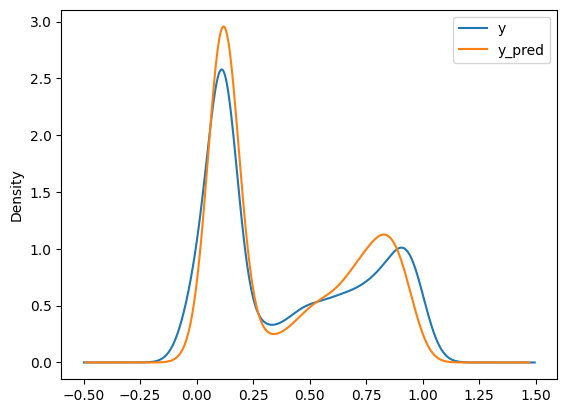

In [235]:
plt.figure(figsize=(12, 10))
    
temp_df = pd.DataFrame({"y": y_test, "y_pred": y_hat_test})
temp_df.plot.kde()
plt.show()